# Weather Data Analysis 

### Let's import flow data.csv file and see what information it contains 

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import calendar
import matplotlib.dates as mdates



In [4]:
flow_data = pd.read_csv('flow data.csv')
flow_data.head(5)

﻿Daily Discharge (m3/s) (PARAM = 1) and Daily Water Level (m) (PARAM = 2)
ID      PARAM Date       Value                                                SYM                       
02HC027 1     1966/07/04 0.357                                                NaN                       
              1966/07/05 0.249                                                NaN                       
              1966/07/06 0.275                                                NaN                       
              1966/07/07 0.337                                                NaN

### It looks like first row of the csv changes the structure of the dataframe (Daily Discharge (m3/s) (PARAM = 1) and Daily Water Level (m) (PARAM = 2)). Hence, we should drop it when downloading. 

In [5]:
flow_data = pd.read_csv('flow data.csv', skiprows=1)


In [188]:
flow_data.head(5)

,ID,PARAM,Date,Value,SYM
0,02HC027,1,1966/07/04,0.357,NaN
1,02HC027,1,1966/07/05,0.249,NaN
2,02HC027,1,1966/07/06,0.275,NaN
3,02HC027,1,1966/07/07,0.337,NaN
4,02HC027,1,1966/07/08,0.252,NaN


### Now we will create two new dataframes each for daily discharge and for daily water level and merge them 

In [6]:
# Create separate DataFrames for PARAM = 1 and PARAM = 2 
param_1_data = flow_data[flow_data["PARAM"] == 1][["ID", "Date", "Value"]].rename(columns={"Value": "daily_discharge"})
param_2_data = flow_data[flow_data["PARAM"] == 2][["ID", "Date", "Value"]].rename(columns={"Value": "water_level"})

# Merge the two DataFrames on ID and Date
flow_data_merged = pd.merge(param_1_data, param_2_data, on=["ID", "Date"], how="outer")

# Verify the merged DataFrame
print(flow_data_merged)


            ID        Date  daily_discharge  water_level
0      02HC027  1966/07/04            0.357          NaN
1      02HC027  1966/07/05            0.249          NaN
2      02HC027  1966/07/06            0.275          NaN
3      02HC027  1966/07/07            0.337          NaN
4      02HC027  1966/07/08            0.252          NaN
...        ...         ...              ...          ...
43002  02HC024  2022/12/27            2.280       12.141
43003  02HC024  2022/12/28            2.150       12.134
43004  02HC024  2022/12/29            2.490       12.151
43005  02HC024  2022/12/30            4.920       12.249
43006  02HC024  2022/12/31           26.400       12.767

[43007 rows x 4 columns]


In [7]:
flow_data_merged.describe()

,daily_discharge,water_level
count,43007.000000,15623.000000
mean,2.504642,6.147701
std,4.108611,5.907381
min,0.042000,0.199000
25%,0.370000,0.341000
50%,1.550000,0.855000
75%,2.700000,12.166000
max,108.000000,13.541000


In [8]:
# Convert the 'Date' column to datetime format
flow_data_merged["Date"] = pd.to_datetime(flow_data_merged["Date"])
flow_data_merged = flow_data_merged.sort_values(by="Date").reset_index(drop=True)


# Verify the changes
print(flow_data_merged.info())  # Confirm that the 'Date' column is now datetime
print(flow_data_merged.head())  # Inspect the first few rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43007 entries, 0 to 43006
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               43007 non-null  object        
 1   Date             43007 non-null  datetime64[ns]
 2   daily_discharge  43007 non-null  float64       
 3   water_level      15623 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.3+ MB
None
        ID       Date  daily_discharge  water_level
0  02HC024 1962-10-01             2.15          NaN
1  02HC024 1962-10-02             1.98          NaN
2  02HC024 1962-10-03             1.87          NaN
3  02HC024 1962-10-04             1.87          NaN
4  02HC024 1962-10-05             6.37          NaN


In [9]:
# Filter rows where water_level is not null
water_level_available = flow_data_merged[flow_data_merged["water_level"].notnull()]

# Find the minimum and maximum dates
min_date = water_level_available["Date"].min()
max_date = water_level_available["Date"].max()

# Print the range
print(f"Water level is available from {min_date} to {max_date}.")

Water level is available from 2002-01-01 00:00:00 to 2023-12-31 00:00:00.


### The Water level measuremnts only available from 2002-01-01 till 2023-12-31. Hence, we will constrain the data to these dates

In [10]:
start_date = "2002-01-01"
end_date = "2023-12-31"

# Filter the DataFrame to only include rows within the specified range
flow_data_merged = flow_data_merged[(flow_data_merged["Date"] >= start_date) & (flow_data_merged["Date"] <= end_date)]
flow_data_merged = flow_data_merged.sort_values(by="Date").reset_index(drop=True)

# Verify the filtered DataFrame
print(flow_data_merged)

            ID       Date  daily_discharge  water_level
0      02HC024 2002-01-01            1.560       12.114
1      02HC027 2002-01-01            0.193        0.263
2      02HC024 2002-01-02            1.490       12.108
3      02HC027 2002-01-02            0.186        0.305
4      02HC027 2002-01-03            0.185        0.252
...        ...        ...              ...          ...
15700  02HC027 2023-12-27            3.790        0.693
15701  02HC027 2023-12-28            1.830        0.680
15702  02HC027 2023-12-29            1.850        0.622
15703  02HC027 2023-12-30            1.310        0.575
15704  02HC027 2023-12-31            0.630        0.401

[15705 rows x 4 columns]


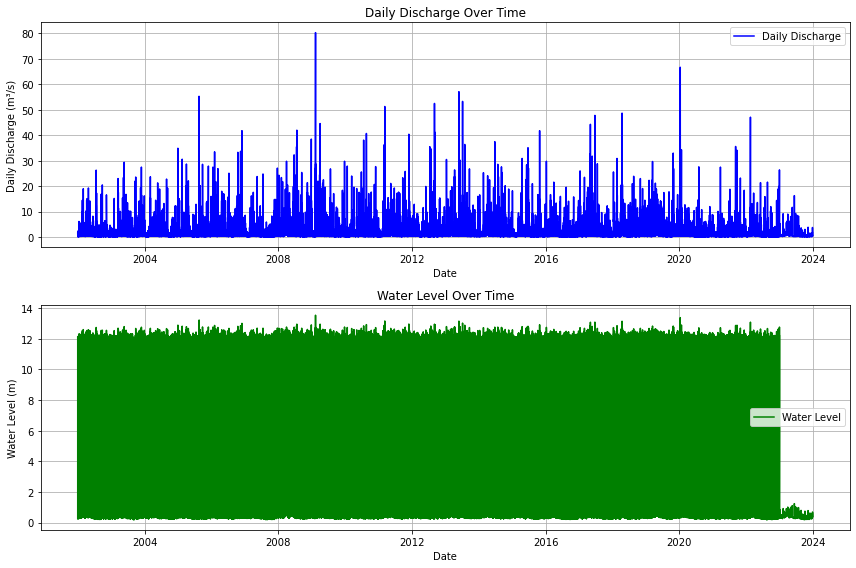

In [11]:
plt.figure(figsize=(12, 8))

# Subplot 1: Daily Discharge
plt.subplot(2, 1, 1)  
plt.plot(flow_data_merged["Date"], flow_data_merged["daily_discharge"], label="Daily Discharge", color="blue")
plt.xlabel("Date")
plt.ylabel("Daily Discharge (m³/s)")
plt.title("Daily Discharge Over Time")
plt.grid(True)
plt.legend()

# Subplot 2: Water Level
plt.subplot(2, 1, 2)  
plt.plot(flow_data_merged["Date"], flow_data_merged["water_level"], label="Water Level", color="green")
plt.xlabel("Date")
plt.ylabel("Water Level (m)")
plt.title("Water Level Over Time")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### We can notice that Water level data is hard to understand, so we will try to aggreagte by month 

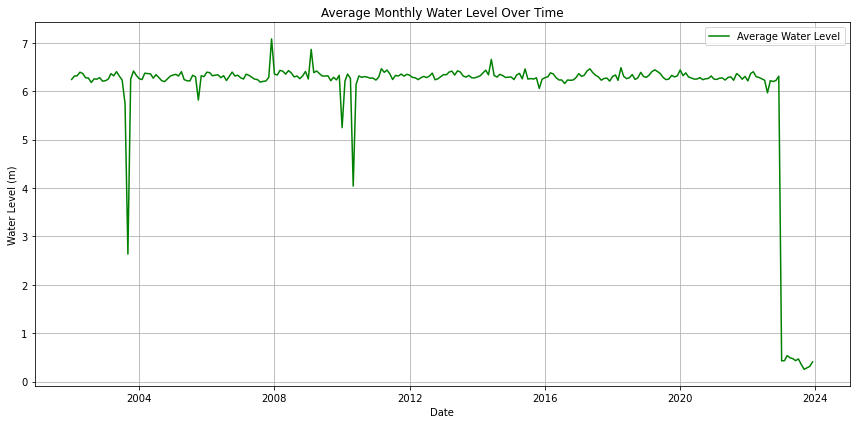

In [13]:
# Create a new column for Year-Month
flow_data_merged["YearMonth"] = flow_data_merged["Date"].dt.to_period("M").dt.to_timestamp()

# Group by Year-Month and calculate average water level
monthly_water_level = flow_data_merged.groupby("YearMonth")["water_level"].mean().reset_index()

# Plot the monthly average water level
plt.figure(figsize=(12, 6))
plt.plot(monthly_water_level["YearMonth"], monthly_water_level["water_level"], color="green", label="Average Water Level")
plt.xlabel("Date")
plt.ylabel("Water Level (m)")
plt.title("Average Monthly Water Level Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


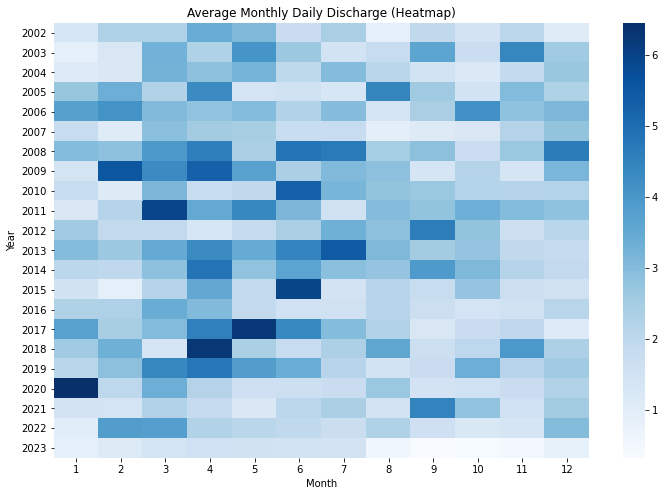

In [14]:
# Extract year and month
flow_data_merged["Year"] = flow_data_merged["Date"].dt.year
flow_data_merged["Month"] = flow_data_merged["Date"].dt.month

# Create a pivot table for heatmap
heatmap_data = flow_data_merged.pivot_table(index="Year", columns="Month", values="daily_discharge", aggfunc="mean")

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="Blues", annot=False)
plt.title("Average Monthly Daily Discharge (Heatmap)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()


## Let's try to incorporate snowmelt data and analyze the correlation 

In [15]:
snowmelt_data = pd.read_csv('significant_snow_melt_events_after_freeze.csv')
snowmelt_data.head()

,start_date,end_date,duration,mean_temperature
0,2002-06-04,2002-11-15,165,18.391515
1,2002-11-18,2002-11-26,9,3.566667
2,2002-12-10,2002-12-15,6,2.100000
3,2002-12-18,2002-12-22,5,3.040000
4,2003-03-15,2003-03-29,15,6.420000


In [16]:
# Ensure the date columns in both datasets are in datetime format
snowmelt_data["start_date"] = pd.to_datetime(snowmelt_data["start_date"])
snowmelt_data["end_date"] = pd.to_datetime(snowmelt_data["end_date"])
flow_data_merged["Date"] = pd.to_datetime(flow_data_merged["Date"])

# Add a column indicating whether a date falls within a snowmelt event
flow_data_merged["snowmelt_event"] = flow_data_merged["Date"].apply(
    lambda x: any((x >= start and x <= end) for start, end in zip(snowmelt_data["start_date"], snowmelt_data["end_date"]))
)


In [17]:
flow_data_merged.head()

,ID,Date,daily_discharge,water_level,YearMonth,Year,Month,snowmelt_event
0,02HC024,2002-01-01,1.560,12.114,2002-01-01,2002,1,False
1,02HC027,2002-01-01,0.193,0.263,2002-01-01,2002,1,False
2,02HC024,2002-01-02,1.490,12.108,2002-01-01,2002,1,False
3,02HC027,2002-01-02,0.186,0.305,2002-01-01,2002,1,False
4,02HC027,2002-01-03,0.185,0.252,2002-01-01,2002,1,False


In [18]:
# Filter data for snowmelt and non-snowmelt periods
snowmelt_period_data = flow_data_merged[flow_data_merged["snowmelt_event"] == True]
non_snowmelt_period_data = flow_data_merged[flow_data_merged["snowmelt_event"] == False]

# Compute summary statistics
print("Snowmelt Period Statistics:")
print(snowmelt_period_data[["daily_discharge", "water_level"]].describe())

print("\nNon-Snowmelt Period Statistics:")
print(non_snowmelt_period_data[["daily_discharge", "water_level"]].describe())


Snowmelt Period Statistics:
       daily_discharge   water_level
count     11684.000000  11616.000000
mean          2.709326      6.134863
std           4.244715      5.908261
min           0.064000      0.199000
25%           0.406000      0.339000
50%           1.550000      0.853500
75%           3.040000     12.171000
max          80.300000     13.541000

Non-Snowmelt Period Statistics:
       daily_discharge  water_level
count      4021.000000  4007.000000
mean          2.147509     6.184917
std           3.471583     5.905409
min           0.086000     0.209000
25%           0.370000     0.346000
50%           1.480000     0.873000
75%           2.520000    12.157000
max          66.700000    13.385000


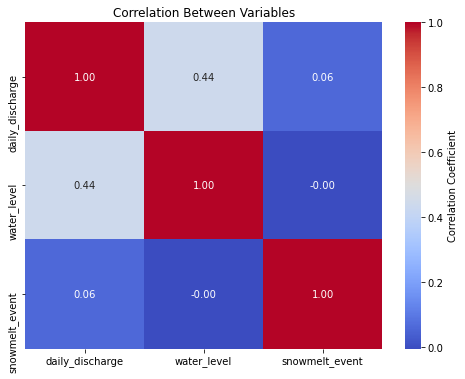

In [19]:
# Select relevant columns for correlation
correlation_data = flow_data_merged[["daily_discharge", "water_level", "snowmelt_event"]].dropna()

# Compute correlation
correlation_matrix = correlation_data.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={"label": "Correlation Coefficient"})
plt.title("Correlation Between Variables")
plt.show()


### Let's look at the yearly average discharge and analyze the data

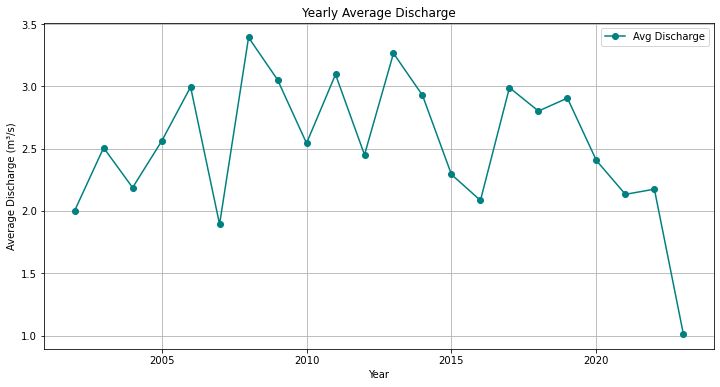

In [20]:
# Aggregate by year
yearly_discharge = flow_data_merged.groupby(flow_data_merged["Date"].dt.year)["daily_discharge"].mean().reset_index()
yearly_discharge.columns = ["Year", "Avg Discharge"]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(yearly_discharge["Year"], yearly_discharge["Avg Discharge"], color="teal", marker="o", label="Avg Discharge")
plt.xlabel("Year")
plt.ylabel("Average Discharge (m³/s)")
plt.title("Yearly Average Discharge")
plt.grid(True)
plt.legend()
plt.show()


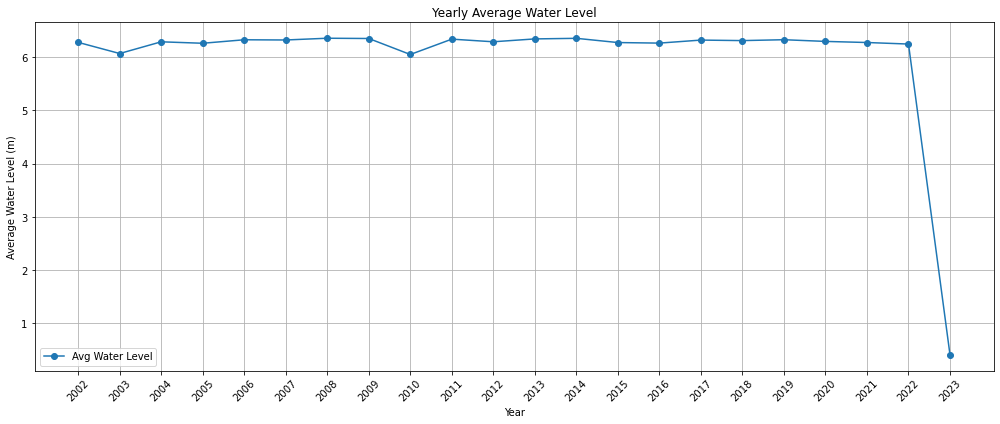

In [21]:
# Group by Year and calculate average water level
yearly_avg_water_level = flow_data_merged.groupby(flow_data_merged["Date"].dt.year)["water_level"].mean()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(yearly_avg_water_level.index, yearly_avg_water_level.values, marker="o", label="Avg Water Level")

# Add more x-axis ticks
years = yearly_avg_water_level.index
plt.xticks(np.arange(years.min(), years.max() + 1, step=1), rotation=45)

# Labels and title
plt.xlabel("Year")
plt.ylabel("Average Water Level (m)")
plt.title("Yearly Average Water Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


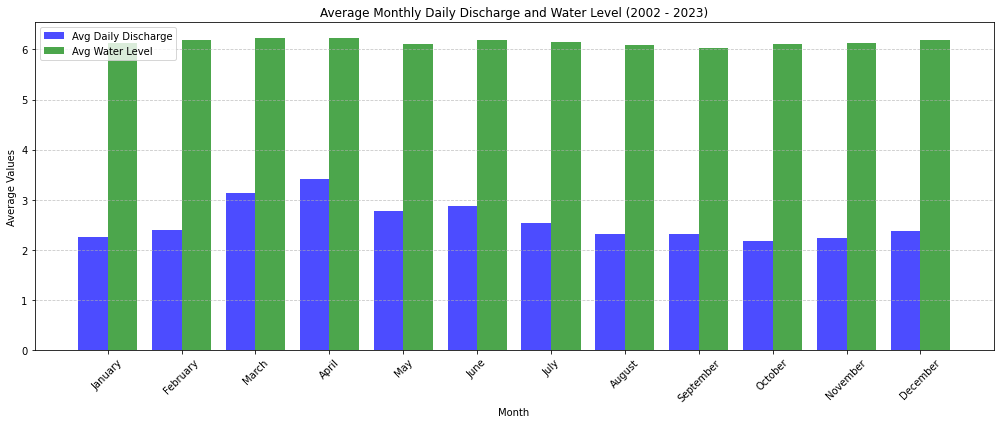

In [24]:
# Group by Month and calculate average for discharge and water level
monthly_avg = flow_data_merged.groupby(flow_data_merged["Date"].dt.month)[["daily_discharge", "water_level"]].mean()

# Rename the index to month names
monthly_avg.index = [calendar.month_name[i] for i in monthly_avg.index]

# Plot bar plot
plt.figure(figsize=(14, 6))

# Bar width and positions
x = range(len(monthly_avg))
width = 0.4

# Plot for daily discharge
plt.bar(x, monthly_avg["daily_discharge"], width=width, label="Avg Daily Discharge", color="blue", alpha=0.7)

# Plot for water level
plt.bar([i + width for i in x], monthly_avg["water_level"], width=width, label="Avg Water Level", color="green", alpha=0.7)

# X-axis labels and title
plt.xticks([i + width / 2 for i in x], monthly_avg.index, rotation=45)
plt.xlabel("Month")
plt.ylabel("Average Values")
plt.title("Average Monthly Daily Discharge and Water Level (2002 - 2023)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


### We can notice that daily discharge starts to increase during snowmelt period. However for better visualization let's focus on last 10 years

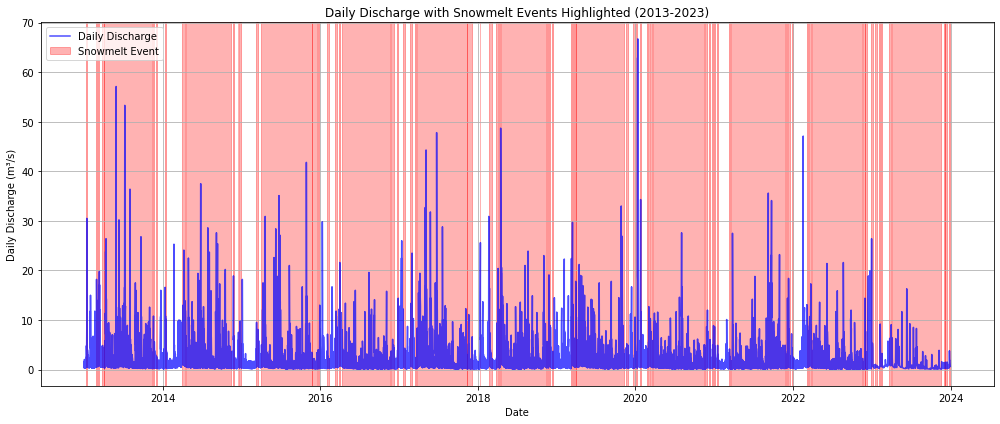

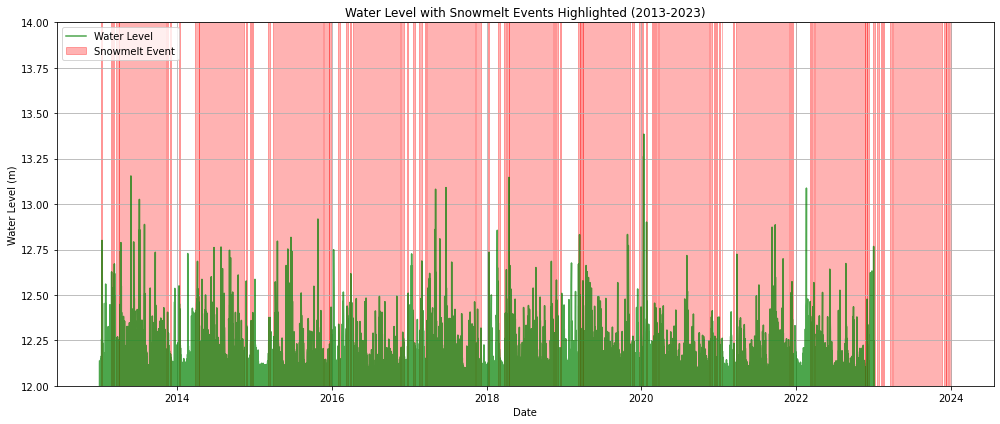

In [25]:
# Define the desired date range 
start_date = pd.Timestamp("2013-01-01")
end_date = pd.Timestamp("2023-12-31")

# Plot Daily Discharge with Snowmelt Events Highlighted
plt.figure(figsize=(14, 6))
plt.plot(
    flow_data_merged[(flow_data_merged["Date"] >= start_date) & (flow_data_merged["Date"] <= end_date)]["Date"],
    flow_data_merged[(flow_data_merged["Date"] >= start_date) & (flow_data_merged["Date"] <= end_date)]["daily_discharge"],
    label="Daily Discharge",
    color="blue",
    alpha=0.7,
)

# Highlight snowmelt periods
added_legend = False
for _, row in snowmelt_data[(snowmelt_data["start_date"] >= start_date) & (snowmelt_data["end_date"] <= end_date)].iterrows():
    plt.axvspan(
        row["start_date"],
        row["end_date"],
        color="red",
        alpha=0.3,
        label="Snowmelt Event" if not added_legend else None,  # Add legend only once
    )
    added_legend = True

plt.xlabel("Date")
plt.ylabel("Daily Discharge (m³/s)")
plt.title("Daily Discharge with Snowmelt Events Highlighted (2013-2023)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Water Level with Snowmelt Events Highlighted
plt.figure(figsize=(14, 6))
plt.plot(
    flow_data_merged[(flow_data_merged["Date"] >= start_date) & (flow_data_merged["Date"] <= end_date)]["Date"],
    flow_data_merged[(flow_data_merged["Date"] >= start_date) & (flow_data_merged["Date"] <= end_date)]["water_level"],
    label="Water Level",
    color="green",
    alpha=0.7,
)

# Highlight snowmelt periods
added_legend = False
for _, row in snowmelt_data[(snowmelt_data["start_date"] >= start_date) & (snowmelt_data["end_date"] <= end_date)].iterrows():
    plt.axvspan(
        row["start_date"],
        row["end_date"],
        color="red",
        alpha=0.3,
        label="Snowmelt Event" if not added_legend else None,  # Add legend only once
    )
    added_legend = True

plt.xlabel("Date")
plt.ylabel("Water Level (m)")
plt.title("Water Level with Snowmelt Events Highlighted (2013-2023)")
plt.ylim(12, 14)  # Set y-axis limits for water level
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


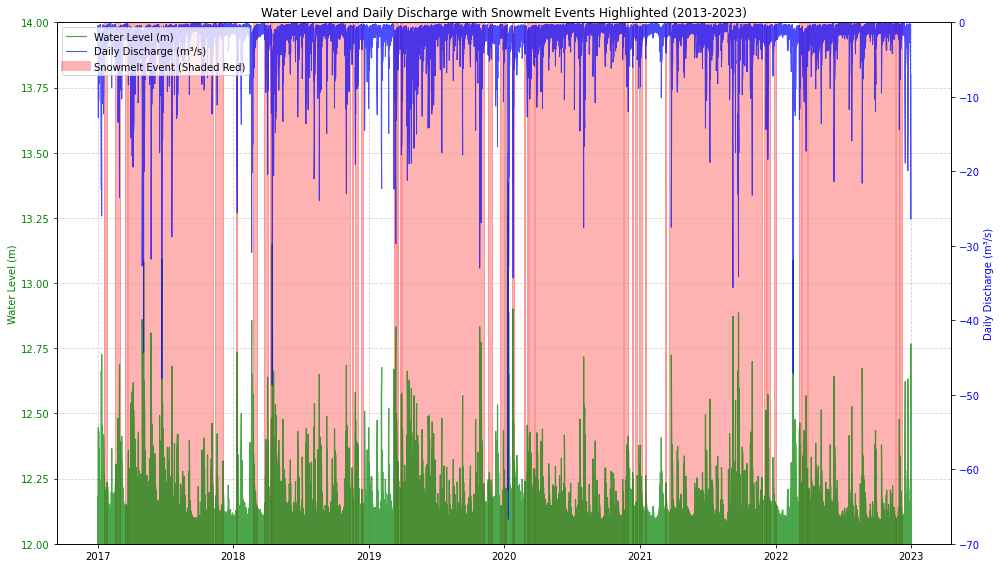

In [30]:
# Define the date range 
start_date = pd.Timestamp("2017-01-01")
end_date = pd.Timestamp("2022-12-31")

# Filter data for the given date range
filtered_data = flow_data_merged[
    (flow_data_merged["Date"] >= start_date) & (flow_data_merged["Date"] <= end_date)
]

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Water Level (Above the X-Axis)
water_level_line = ax1.plot(
    filtered_data["Date"],
    filtered_data["water_level"],
    label="Water Level (m)",
    color="green",
    alpha=0.7,
    linewidth=1.2,
)

# Set Water Level axis properties
ax1.set_ylabel("Water Level (m)", color="green")
ax1.set_ylim(12, 14)  # Limit Water Level from 12m to 14m
ax1.tick_params(axis="y", labelcolor="green")

# Add a secondary axis for Daily Discharge (Below the X-Axis)
ax2 = ax1.twinx()
daily_discharge_line = ax2.plot(
    filtered_data["Date"],
    -filtered_data["daily_discharge"],  # Flip discharge values to go below X-axis
    label="Daily Discharge (m³/s)",
    color="blue",
    alpha=0.7,
    linewidth=1,
)

# Set Daily Discharge axis properties
ax2.set_ylabel("Daily Discharge (m³/s)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.set_ylim(-70, 0)  # Set discharge values below the x-axis

# Highlight Snowmelt Events
for _, row in snowmelt_data[
    (snowmelt_data["start_date"] >= start_date) & (snowmelt_data["end_date"] <= end_date)
].iterrows():
    ax1.axvspan(
        row["start_date"],
        row["end_date"],
        color="red",
        alpha=0.3,
    )

# Add a legend entry for Snowmelt Event
snowmelt_patch = plt.Line2D(
    [0], [0],
    color="red",
    alpha=0.3,
    linewidth=10,
    label="Snowmelt Event (Shaded Red)"
)

# Format X-axis
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)

# Add grid, title, and legend
plt.title("Water Level and Daily Discharge with Snowmelt Events Highlighted (2013-2023)")
ax1.grid(True, linestyle="--", alpha=0.6)

# Combine Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2 + [snowmelt_patch], labels1 + labels2 + ["Snowmelt Event (Shaded Red)"], loc="upper left")

# Adjust layout and show plot
plt.tight_layout()
plt.show()


## Now let's analyze how significant rain events impact water level and daily discharge 

In [32]:
significant_rain_events = pd.read_csv('significant_rain_events_filtered.csv')

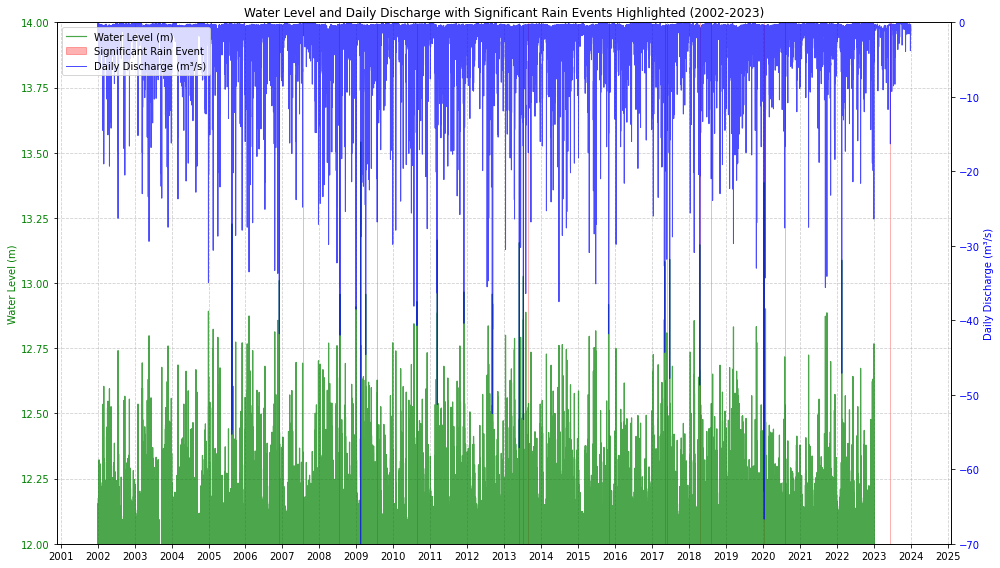

In [39]:
# Define the desired date range 
start_date = pd.Timestamp("2002-01-01")
end_date = pd.Timestamp("2023-12-31")

# Filter flow_data_merged for the given date range
filtered_data = flow_data_merged[
    (flow_data_merged["Date"] >= start_date) & (flow_data_merged["Date"] <= end_date)
]

# Filter significant_rain_events for the date range and convert dates to datetime 
significant_rain_events["start_date"] = pd.to_datetime(significant_rain_events["start_date"])
significant_rain_events["end_date"] = pd.to_datetime(significant_rain_events["end_date"])
filtered_rain_events = significant_rain_events[
    (significant_rain_events["start_date"] >= start_date) & 
    (significant_rain_events["end_date"] <= end_date)
]

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Water Level 
ax1.plot(
    filtered_data["Date"],
    filtered_data["water_level"],
    label="Water Level (m)",
    color="green",
    alpha=0.7,
    linewidth=1.2,
)

# Set Water Level axis properties
ax1.set_ylabel("Water Level (m)", color="green")
ax1.set_ylim(12, 14)  # Limit Water Level from 12m to 14m
ax1.tick_params(axis="y", labelcolor="green")

# Add a secondary axis for Daily Discharge 
ax2 = ax1.twinx()
ax2.plot(
    filtered_data["Date"],
    -filtered_data["daily_discharge"],  
    label="Daily Discharge (m³/s)",
    color="blue",
    alpha=0.7,
    linewidth=1,
)

# Set Daily Discharge axis properties
ax2.set_ylabel("Daily Discharge (m³/s)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.set_ylim(-70, 0)  

# Highlight Significant Rain Events
for _, row in filtered_rain_events.iterrows():
    ax1.axvspan(
        row["start_date"],
        row["end_date"],
        color="red",
        alpha=0.3,
        label="Significant Rain Event" if _ == 0 else None,
    )

# Format X-axis
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)

# Add grid, title, and legend
plt.title("Water Level and Daily Discharge with Significant Rain Events Highlighted (2002-2023)")
ax1.grid(True, linestyle="--", alpha=0.6)

# Combine Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# Adjust layout and show plot
plt.tight_layout()
plt.show()
